# Investigating RNNs and RL using the N-back cognitive task

**NMA 2023 Group 1 Project**

__Content creators:__ Aland Astudillo, Campbell Border, Disheng, Julia Yin, Koffivi

__Pod TA:__ Suryanarayanan Nagar Anthel Venkatesh

__Project Mentor:__ 

---
# Objective

- 

- 
---

# Project Design
---

# Setup

## Install Dependencies

In [1]:
# @title Install dependencies
%pip install jedi --quiet
%pip install --upgrade pip setuptools wheel --quiet
%pip install numpy==1.23.3 --quiet --ignore-installed
%pip install gymnasium --quiet
%pip install torch --quiet
%pip install matplotlib --quiet
%pip uninstall seaborn -y --quiet
%pip install seaborn --quiet
#!pip install trfl --quiet\n"

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [12]:
# @title Imports
import math
import numpy as np
from numpy.random import default_rng
import gymnasium as gym
from gymnasium import register
from gymnasium import spaces
import torch
from torch import nn
from torch import optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn as sns
import random

## Figure settings

In [13]:
# @title Figure settings
from IPython.display import clear_output, display, HTML
%matplotlib inline
sns.set()

---
# Background

## Replace with our own literature review

- Cognitive scientists use standard lab tests to tap into specific processes in the brain and behavior. Some examples of those tests are Stroop, N-back, Digit Span, TMT (Trail making tests), and WCST (Wisconsin Card Sorting Tests).

- Despite an extensive body of research that explains human performance using descriptive what-models, we still need a more sophisticated approach to gain a better understanding of the underlying processes (i.e., a how-model).

- Interestingly, many of such tests can be thought of as a continuous stream of stimuli and corresponding actions, that is in consonant with the RL formulation. In fact, RL itself is in part motivated by how the brain enables goal-directed behaviors using reward systems, making it a good choice to explain human performance.

- One behavioral test example would be the N-back task.

  - In the N-back, participants view a sequence of stimuli, one by one, and are asked to categorize each stimulus as being either match or non-match. Stimuli are usually numbers, and feedback is given at both timestep and trajectory levels.

  - The agent is rewarded when its response matches the stimulus that was shown N steps back in the episode. A simpler version of the N-back uses two-choice action schema, that is match vs non-match. Once the present stimulus matches the one presented N step back, then the agent is expected to respond to it as being a `match`.


- Given a trained RL agent, we then find correlates of its fitted parameters with the brain mechanisms. The most straightforward composition could be the correlation of model parameters with the brain activities.

## Datasets

- Human Connectome Project Working Memory (HCP WM) task ([NMA-CN HCP notebooks](https://github.com/NeuromatchAcademy/course-content/tree/master/projects/fMRI))

1200 subjects, each subject experience 8 blocks of 2-back and 8 blocks of 0-back.

## N-back Tasks

In the N-back task, participants view a sequence of stimuli, one per time, and are asked to categorize each stimulus as being either match or non-match. Stimuli are usually numbers, and feedbacks are given at both timestep and trajectory levels.

In a typical neuro setup, both accuracy and response time are measured, but here, for the sake of brevity, we focus only on accuracy of responses.

- 2 back working memory task:

The second condition is a 2-Back condition. During such a block, the subject is presented with a sequence of 10 images and must respond if each image is identical to the one 2 positions earlier or not (figure, right). At the beginning of the block there is a cue screen informing the subject that the upcoming stimuli are part of the 2-Back protocol. The timing of the cue screen, the presentation of the 10 stimulus images and of the response interval are identical to that of the 0-Back condition.

- 0-back control memory task:

The first is a match-to-sample condition (termed in the following text as 0-Back) during which a cue “Target” image is presented at the beginning of a block and which the subject has been instructed to memorize. Then a sequence of 10 images is presented. 


Any dataset that used cognitive tests would work.
Question: limit to behavioral data vs fMRI?
Question: Which stimuli and actions to use?
classic tests can be modeled using 1) bounded symbolic stimuli/actions (e.g., A, B, C), but more sophisticated one would require texts or images (e.g., face vs neutral images in social stroop dataset)
The HCP dataset from NMA-CN contains behavioral and imaging data for 7 cognitive tests including various versions of N-back.


Details of the tMEG Working Memory task

Working memory is assessed using an N-back task in which participants are asked to monitor
sequentially presented pictures. Participants are presented with blocks of trials that consisted of
pictures of tools or faces. Within each run, the 2 different stimulus types are presented in
separate blocks. Also, within each run, ½ of the blocks use a 2-back working memory task and
½ use a 0-back working memory task (as a working memory comparison). Participants are
instructed to press a button for every picture. If the currently presented picture matches the
cued picture (0-Back) or the same picture that was presented two pictures before (2-Back),
subjects press one button with their right index finger. For non-matching pictures, participants
press a second button with their right middle finger. Two runs are performed, 16 blocks each,
with a bright fixation "rest" on dark background for 15 seconds between blocks. 

- Special modelling of images (we are probably not going to model this)

There are 2 different categories of images used in this experiment: images of faces and tools.
Each block contains images from a single category. Some of the images in the non-matched
trials have been characterized as “Lure”. These images have been selected so that they have
common features with the target image, but are still different. These trials as flagged as “Lure”.
I


https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf Page 72

---
## Implementation scheme

### Environment

The following cell implments N-back envinronment, that we later use to train a RL agent on human data. It is capable of performing two kinds of simulation:
- rewards the agent once the action was correct (i.e., a normative model of the environment).
- receives human data (or mock data if you prefer), and returns what participants performed as the observation. This is more useful for preference-based RL.

In [14]:
# Test environment

register(
    id='NBack-v0',
    entry_point='nback_env:NBack',
)

env = gym.make(
    'NBack-v0',
    N = 2,
    num_trials=25,
    num_targets=5,
    rewards=(1, 0, 0, 0),
    num_obs=5,
    seed=42
    )

obs, info = env.reset()
print(env.sequence)
print(env.step_count, obs)
done = False
while not done:
  obs, reward, done, info  = env.step(0)
  if obs[-1] == obs[-3]:
    print(env.step_count, obs, "MATCH")
  else:
    print(env.step_count, obs)

[3 0 3 0 4 3 7 7 6 2 0 0 2 5 6 5 5 5 2 5 7 1 4 0 0 4 2]
0 [0 0 0 0 3]
1 [0 0 0 3 0] MATCH
2 [0 0 3 0 3] MATCH
3 [0 3 0 3 0] MATCH
4 [3 0 3 0 4]
5 [0 3 0 4 3]
6 [3 0 4 3 7]
7 [0 4 3 7 7]
8 [4 3 7 7 6]
9 [3 7 7 6 2]
10 [7 7 6 2 0]
11 [7 6 2 0 0]
12 [6 2 0 0 2]
13 [2 0 0 2 5]
14 [0 0 2 5 6]
15 [0 2 5 6 5] MATCH
16 [2 5 6 5 5]
17 [5 6 5 5 5] MATCH
18 [6 5 5 5 2]
19 [5 5 5 2 5] MATCH
20 [5 5 2 5 7]
21 [5 2 5 7 1]
22 [2 5 7 1 4]
23 [5 7 1 4 0]
24 [7 1 4 0 0]
25 [1 4 0 0 4]
26 [4 0 0 4 2]
27 [0 0 4 2 0]


/Users/campbellborder/Projects/NMA/NMA-group1/.conda/lib/python3.11/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment NBack-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/Users/campbellborder/Projects/NMA/NMA-group1/.conda/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:181: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.deprecation(
/Users/campbellborder/Projects/NMA/NMA-group1/.conda/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:135: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be float32, actual type: int64
  logger.warn(
/Users/campbellborder/Projects/NMA/NMA-group1/.conda/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: W

### Define a random agent

In [15]:
# Random agent
class RandomAgent(nn.Module):
    
    def __init__(self, env):
        super().__init__()
        self.env = env

    # Choose a random action, 0 or 1
    def choose_action(self, seq):
        return np.random.randint(0, 2)

    def test(self, num_episodes):
        
        # Arrays to hold true/false positives and false negatives
        tps = np.zeros(num_episodes)
        fps = np.zeros_like(tps)
        fns = np.zeros_like(tps)

        for i in range(num_episodes):
            
            # Array of actions
            actions = np.zeros(self.env.episode_length, dtype=int)

            # Perform action for each element in sequence
            seq, info = self.env.reset()
            done = False
            while not done:
                action = self.choose_action(seq)
                actions[info['step_count']] = action
                seq, reward, done, info = self.env.step(action)
            
            # Get episode data
            actions = actions[self.env.N:]
            correct_actions = self.env.correct_actions
            tps[i] = np.dot(actions, correct_actions) 
            fps[i] = np.dot(actions, 1 - correct_actions)
            fns[i] = np.dot(1 - actions, correct_actions)

        return tps, fps, fns

/Users/campbellborder/Projects/NMA/NMA-group1/.conda/lib/python3.11/site-packages/gymnasium/core.py:297: UserWarning: WARN: env.episode_length to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.episode_length` for environment variables or `env.get_attr('episode_length')` that will search the reminding wrappers.
  logger.warn(
/Users/campbellborder/Projects/NMA/NMA-group1/.conda/lib/python3.11/site-packages/gymnasium/core.py:297: UserWarning: WARN: env.N to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.N` for environment variables or `env.get_attr('N')` that will search the reminding wrappers.
  logger.warn(
/Users/campbellborder/Projects/NMA/NMA-group1/.conda/lib/python3.11/site-packages/gymnasium/core.py:297: UserWarning: WARN: env.correct_actions to get variables from other wrappers is deprecated and will be removed in v1.0, to get 

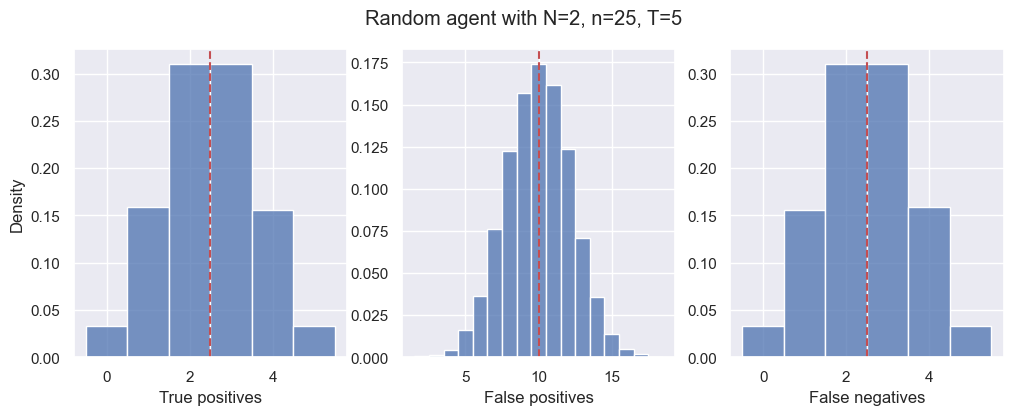

In [16]:
# @title Test random agent
# Create environment, random agent and test
N = 2
n = 25
T = 5

env = gym.make(
    'NBack-v0',
    N = 2,
    num_trials=25,
    num_targets=5,
    rewards=(1, 0, 0, 0),
    num_obs=5,
    seed=42
    )

agent = RandomAgent(env=env)
results = agent.test(10000)

fig = plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
fig.suptitle(f"Random agent with N={N}, n={n}, T={T}")
sns.histplot(results[0], stat="density", bins=4, discrete=True)
plt.axvline(T/2, color='r', linestyle='--')
plt.xlabel('True positives')

plt.subplot(1, 3, 2)
sns.histplot(results[1], stat="density", bins=17, discrete=True)
plt.axvline((n-T)/2, color='r', linestyle='--')
plt.xlabel('False positives')
plt.ylabel('')

plt.subplot(1, 3, 3)
sns.histplot(results[2], stat="density", bins=4, discrete=True)
plt.axvline(T/2, color='r', linestyle='--')
plt.xlabel('False negatives')
plt.ylabel('')
plt.show()

### Define a simple Q-learning agent

In [17]:
# Neural network representing the Q-function
class DQN(nn.Module):
  def __init__(self, num_obs, num_actions, hidden_sizes=[], actv="ReLU()"):
    super().__init__()

    self.num_obs = num_obs
    self.num_actions = num_actions
    self.hidden_sizes = hidden_sizes
    self.mlp = nn.Sequential()

    # Create net
    prev_size = self.num_obs # Initialize the temporary input feature to each layer
    for i in range(len(hidden_sizes)): # Loop over layers and create each one
        
        # Add linear layer
        current_size = hidden_sizes[i] # Assign the current layer hidden unit from list
        layer = nn.Linear(prev_size, current_size)
        prev_size = current_size # Assign next layer input using current layer output
        self.mlp.add_module('Linear_%d'%i, layer) # Append layer to the model

        # Add activation function
        actv_layer = eval('nn.%s'%actv) # Assign activation function (eval allows us to instantiate object from string)
        self.mlp.add_module('Activation_%d'%i, actv_layer) # Append activation to the model with a name

    out_layer = nn.Linear(prev_size, self.num_actions) # Create final layer
    self.mlp.add_module('Output_Linear', out_layer) # Append the final layer

  def forward(self, x):
    x = torch.tensor(x, dtype=torch.float)
    return self.mlp(x)

In [18]:
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, state, action, next_state, reward, done):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = (state, action, next_state, reward, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.memory, batch_size)
        states, actions, next_states, rewards, dones = zip(*batch)
        return np.stack(states), actions, np.stack(next_states), rewards, dones

    def __len__(self):
        return len(self.memory)

In [19]:
def train(model, memory, optimizer, criterion, batch_size, gamma, training=True):
    if len(memory) < batch_size:
        return np.array([0])
    states, actions, next_states, rewards, dones = memory.sample(batch_size)
    states = Variable(torch.FloatTensor(states))
    actions = Variable(torch.LongTensor(actions))
    next_states = Variable(torch.FloatTensor(next_states))
    rewards = Variable(torch.FloatTensor(rewards))
    dones = Variable(torch.FloatTensor(dones))

    q_values = model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
    next_q_values = model(next_states).max(1)[0]

    target_q_values = rewards + gamma * next_q_values * (1 - dones)

    loss = criterion(q_values, target_q_values.detach())

    if training:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return loss.detach()


def exec_training(model, env, gamma=0.99, num_episodes = 100, training=True):

    # Create an instance of the replay memory
    capacity = 1000
    memory = ReplayMemory(capacity)

    # Set hyperparameters
    batch_size = 64
    lr = 0.001
    eps_max = 0.08
    eps_min = 0.01
    eps_step = 0.01

    # Set up the optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    tps = np.zeros(num_episodes)
    fps = np.zeros_like(tps)
    fns = np.zeros_like(tps)
    correct = np.zeros_like(tps)
    rewards_list = []
    loss_list = []

    # Training loop
    for episode in range(num_episodes):
        state = env.reset()
        state = state[0]
        done = False
        total_reward = 0
        actions = []

        step_count = 1
        while not done:
            # Select an action using epsilon-greedy policy
            epsilon = max(eps_min, eps_max - eps_step * episode)
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    q_values = model(torch.FloatTensor(state))
                    action = q_values.argmax().item()

            # Take the selected action and observe the next state and reward
            # next_state, reward, done, terminated, truncated = env.step(action)
            next_state, reward, done, info = env.step(action)

            # Store the transition in the replay memory
            memory.push(state, action, next_state, reward, done)

            # Move to the next state
            state = next_state
            total_reward += reward
            actions.append(action)

            # Train the model
            loss = train(model, memory, optimizer, criterion, batch_size, gamma, training)
            step_count += 1

            loss_list.append(loss.mean())

        rewards_list.append(total_reward)
        actions = np.array(actions[2:])
        correct_actions = env.correct_actions
        tps[episode] = np.dot(actions, correct_actions) / sum(correct_actions)
        fps[episode] = np.dot(actions, 1 - correct_actions) / sum(1 - correct_actions)
        fns[episode] = np.dot(1 - actions, correct_actions) / sum(correct_actions)
        correct[episode] = sum(actions == correct_actions) / env.num_trials

        # Print the total reward for the episode
        # print(f"Episode {episode + 1}: Total Reward = {total_reward}")

    return loss_list, rewards_list, tps, fps, fns, correct


In [21]:

# import gymnasium as gym
# from gymnasium import register

# env = gym.make(
#     'NBack-v0',
#     N = 2,
#     num_trials=25,
#     num_targets=5,
#     rewards=(1, 0, -1, -1),
#     num_obs=5,
#     seed=42
#     )

# # Create an instance of the DQN model
# input_size = env.observation_space.shape[0]
# output_size = env.action_space.n
# model = DQN(input_size, output_size, hidden_sizes = [64])

# observation, info = env.reset()
# loss, rewards, tps, fps, fns, correct = exec_training(model=model, env=env, gamma=0, num_episodes = 500)

for episodes in [5, 10, 50, 100, 500, 1000]:

    env = gym.make(
        'NBack-v0',
        N = 2,
        num_trials=25,
        num_targets=5,
        rewards=(1, 0, -1, -1),
        num_obs=5,
        seed=42
        )

    input_size = env.observation_space.shape[0]
    output_size = env.action_space.n
    model = DQN(input_size, output_size, hidden_sizes = [64])

    observation, info = env.reset()
    loss, rewards, tps, fps, fns, correct = exec_training(model=model, env=env, gamma=0, num_episodes = episodes)

    env = gym.make(
        'NBack-v0',
        N = 2,
        num_trials=25,
        num_targets=5,
        rewards=(1, 0, -1, -1),
        num_obs=5,
        seed=21
        )

    observation, info = env.reset()
    loss, rewards, tps, fps, fns, correct = exec_training(model=model, env=env, gamma=0, num_episodes = 500, training=False)

    print(episodes, correct.mean()*100)





/var/folders/z7/863rk6_120x23r3x_f3q_3300000gn/T/ipykernel_7842/2970203738.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float)


5 57.46400000000001
10 78.95200000000001
50 83.92800000000001
100 88.576
500 98.37599999999999
1000 99.52799999999999


Prediction accuracy: 99.34400000000001


/var/folders/z7/863rk6_120x23r3x_f3q_3300000gn/T/ipykernel_6332/2344435676.py:30: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



Text(0.5, 0, 'Episode % 1')

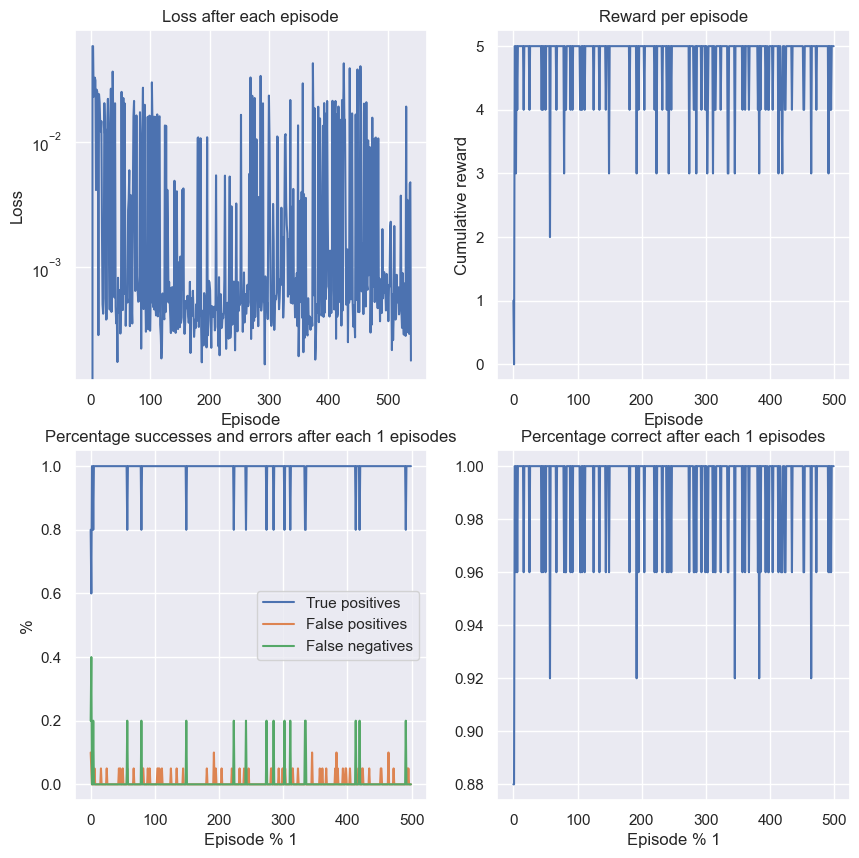

In [ ]:
print(f"Prediction accuracy: {correct.mean() * 100}")

fig = plt.figure(figsize=(10, 10))

# Loss
plt.subplot(2, 2, 1)
plt.plot(loss[::25], '-')
plt.title("Loss after each episode")
plt.yscale("log")
plt.ylabel("Loss")
plt.xlabel("Episode")

# Reward
plt.subplot(2, 2, 2)
plt.plot(rewards, '-')
plt.title("Reward per episode")
plt.ylabel("Cumulative reward")
plt.xlabel("Episode")

# TPs, FPs, FNs
step = 1
plt.subplot(2, 2, 3)
plt.plot(tps[::step])
plt.plot(fps[::step])
plt.plot(fns[::step])
plt.title(f"Percentage successes and errors after each {step} episodes")
plt.legend(["True positives", "False positives", "False negatives"])
plt.ylabel("%")
plt.xlabel(f"Episode % {step}")
fig.show()

# Percentage correct
step = 1
plt.subplot(2, 2, 4)
plt.plot(correct[::step])
plt.title(f"Percentage correct after each {step} episodes")
plt.xlabel(f"Episode % {step}")

### Define a Recurrent Deep Q-learning Agent (RDQN)

### Attempt to define a RNN in pytorch

In [ ]:
"""
Model definition

https://medium.com/@VersuS_/coding-a-recurrent-neural-network-rnn-from-scratch-using-pytorch-a6c9fc8ed4a7

https://www.youtube.com/watch?v=WEV61GmmPrk
"""

class RNN(nn.Module):
    """
    Basic RNN block. This represents a single layer of RNN
    """
    def __init__(self, input_size: int, hidden_size: int, output_size: int) -> None:
        """
        input_size: Number of features of your input vector
        hidden_size: Number of hidden neurons
        output_size: Number of features of your output vector
        """
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size

        # input to hidden
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size, bias=False)
        # input to output
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        # softmax layer
        self.softmax = nn.LogSoftmax(dim = 1)

    
    def forward(self, input_tensor, hidden_tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Returns softmax(linear_out) and tanh(i2h + i2o)
        Inputs
        ------
        x: Input vector x  with shape (vocab_size, )
        hidden_state: Hidden state matrix
        Outputs
        -------
        out: Prediction vector
        hidden_state: New hidden state matrix
        """
        combined = torch.cat((input_tensor, output_tensor), 1)

        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)

        return output, hidden
        

    def init_hidden(self, batch_size=1) -> torch.Tensor:
        """
        Returns a hidden state with specified batch size. Defaults to 1
        """
        return torch.zeros(1, self.hidden_size)

In [ ]:
# training RNN layer

criterion = nn.NLLLoss()
learning_rate = 0.005
optimizer = torch.optim.SGD(rnn.parameters(), lr = learning_rate)

def train(input_tensor, action_tensor):
    hidden = rnn.init_hidden()
    for i in range(input_tensor.size()[0]):
        output, hidden = rnn(input_tensor[i], hidden)


NameError: name 'rnn' is not defined

# Section 4: Model(s)

In [ ]:
# Random agent
class RandomAgent(nn.Module):
    
    

SyntaxError: unexpected EOF while parsing (3220473413.py, line 4)

In [ ]:
# RNN

class LayeredRNN(nn.Module)